In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
# from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.utils.plotting import imshow, random_colors
from mesostat.utils.pandas_helper import merge_df_from_dict
from mesostat.metric.sequence import avg_bivariate_binary_orderability_from_temporal_mean, bivariate_orderability_from_temporal_mean
# from mesostat.stat.connectomics import offdiag_1D
from mesostat.stat.permtests import perm_test, difference_test
from mesostat.stat.resampling import sample


from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity
from src.lib.clustering import cluster_dist_matrix
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/home/alyosha/Desktop/maria/dff/'
# params['root_path_deconv'] = '/home/alyosha/Desktop/maria/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [6]:
significantCellsSelectorDatatype = {}

for datatype in ['raw', 'deconv']:
    signCellsMaintenance = SignificantCells('significant_cells_'+datatype+'_mt.h5').get_cells_by_mouse()
    signCellsReward = SignificantCells('significant_cells_'+datatype+'_enc_reward.h5').get_cells_by_mouse()

    significantCellsSelectorDatatype[datatype] = {
        'None' : None,
        'Maintenance' : signCellsMaintenance,
        'Reward' : signCellsReward
    }

# Q1: Do temporal features predict modality

Predictors:
* mean by cell, variance of mean by cell
* temporal_order by cell -> (cell-wise test, proxy via tsne)
* legendre basis by cell -> (cell-wise base wise test, proxy via tsne)
* var(temp_order) by trial by cell -> (cell-wise test, proxy via tsne)
* var(legendre_basis) by trial by cell -> (cell-wise test, proxy via tsne)
* binary_orderability
    - permutation test on directly on ABO
    - (maybe) significance matrix for each link, test counting (prob. via permutation test)
* sequencability -> proxy via tsne (count if cell does approx 1 spike)

Variations:
* Time : [Stretched, Min-cropped]
* Cells : [All, Significantly active]

## 1.1 Temporal Mean by cell

In [ ]:
def count_significant_cells(dataDB, datatype, selector, condition, metricName, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, metricName, "pr", selector, settings)]
            
        nCells = dataDB.get_nchannel(mousename, datatype)
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    rezDF = pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"])
    return rezDF

In [ ]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            key = (datatype, interval, condition)
            print(key)
            
            rezDF = count_significant_cells(dataDB, datatype, {"interval" : interval}, condition, "ord_mean")
            rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition']))

## 1.2 Variance of Temporal Mean by cell

In [ ]:
diff_func = lambda x,y: np.std(x) - np.std(y)

rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            key = (datatype, interval, condition)
            print(key)
            
            rezDF = count_significant_cells(dataDB, datatype, {"interval" : interval}, condition, "ord_mean", proxyFunc=diff_func, nResample=1000)
            rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition']))

## 1.3 Legendre Basis by cell

In [ ]:
def count_significant_cells_legendre(dataDB, datatype, selector, condition, basisIdx, nResample=1000, pval=0.01, proxyFunc=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, 'temporal_basis', "pr", selector, settings)[:,:,basisIdx]]
            
        nCells = dataDB.get_nchannel(mousename, datatype)
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval, nResample=nResample, proxyFunc=proxyFunc)
            
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 1)]]
        
    rezDF = pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"])
#     display(rezDF)
    return rezDF

In [ ]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            for basisIdx in [1, 2]:            
                key = (datatype, interval, condition, basisIdx)
                print(key)

                rezDF = count_significant_cells_legendre(dataDB, datatype, {"interval" : iInterv}, condition, basisIdx)
                rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'basisIdx']))

### Legendre STD

In [ ]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            for basisIdx in [1, 2]:            
                key = (datatype, interval, condition, basisIdx)
                print(key)

                rezDF = count_significant_cells_legendre(dataDB, datatype, {"interval" : iInterv}, condition, basisIdx, proxyFunc=np.std)
                rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'basisIdx']))

# 2 Testing orderability

1. For each trial and channel, compute temporal means
2. For a set of trials, compute average binary orderability from temporal means
3. Do permutation test on modality trials

In [ ]:
diff_func = lambda x, y: avg_bivariate_binary_orderability_from_temporal_mean(x) - avg_bivariate_binary_orderability_from_temporal_mean(y)

def test_orderability(dataDB, datatype, selector, condition, nResample=1000, pval=0.01, proxyFunc=None, signCellsMouseDict=None):
    nMice = len(dataDB.mice)
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    mouseResults = []
    
    settings = {"dropShortTrialsTHR" : 5}
    settingsTest = {"haveEffectSize" : True, "haveMeans" : True}
    
    if signCellsMouseDict is not None:
        channelFilter = signCellsMouseDict
    else:
        channelFilter = None
    
    rezLst = []
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "ord_mean", "rp", selector, settings, channelFilter=channelFilter)]
            
        pLess, pMore, eff, mu1, mu2 = difference_test(diff_func, means[0], means[1], nSample=1000, sampleFunction="permutation", settings=settingsTest)
        
        rezLst += [[mousename, pLess, pMore, eff, mu1, mu2]]
        
    columnNames = ['mousename', 'pValLess', 'pValMore', 'EffSize', 'diffTrue', 'diffRand']
    
    rezDF = pd.DataFrame(rezLst, columns=columnNames)
#     display(rezDF)
    return rezDF

In [ ]:
rezDFDict = {}
for datatype in ['raw', 'deconv']:
    for interval in range(6, 9):
        for condition in ['performance', 'direction']:
            for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
                key = (datatype, interval, condition, signCellsName)
                print(key)
                
                rezDF = test_orderability(dataDB, datatype, {"interval" : interval}, condition, signCellsMouseDict=signCells)
                rezDFDict[key] = rezDF
            
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'filter']))

# Q2: Presence of relative temporal structure in the firing pattern

Metrics:
* Temporal Mean
* Bivariate Orderability (undirected)
* Bivariate Orderability (directed)

Hypotheses:
* Neurons are more orderable than random - **True**
    * Neurons cluster by being orderable outside cluster but not inside - **True**
        * Can be explained by average timing preference - **True**
    * Exist cells that possess time-invariant orderability - **False**
        * No evidence of orderability beyond average timing
* Some neurons are useless at global orderability

TODO:
* Test if temporal mean is significantly different from 0.5
    * test mean-0.5
    * test var(mean-0.5)
    * mark cells as useful or useless
* Significance of ABO:
    - Permutation-test ABO by interval, including maintenance and retrieval
    - Filter cells, see if filtered have higher orderability

# Stability of Temporal Mean

In [ ]:
nMice = len(dataDB.mice)
fig, ax = plt.subplots(ncols=nMice, figsize=(4*nMice, 4))
    
for iMouse, mousename in enumerate(sorted(dataDB.mice)):

    queryDictThis = {'datatype' : 'deconv', 'mousename' : mousename}

    # Calculate orderability
    dataTempMu = metric_by_selector(dataDB,
                                    queryDictThis,
                                    "ord_mean",
                                    "pr",
                                    {'interval' : 8},
                                    {},
                                    channelFilter=None)


    muTempMu = np.mean(dataTempMu, axis=1)
    stdTempMu = np.std(dataTempMu, axis=1)

    ax[iMouse].plot(np.abs(muTempMu - 0.5), stdTempMu, '.')

plt.show()

In [ ]:
def mat_order_by_idx(M, idx):
    return np.copy(M[idx][:, idx])

def pairwise_subtract(data1D):
    dataExtrudeX = np.outer(np.ones(len(data1D)), data1D)
    return dataExtrudeX - dataExtrudeX.T

def get_mat_triu_elems(m):
    return m[np.triu_indices(m.shape[0])]

## Undirected Orderability

In [ ]:
def plots_orderability(dataDB, queryDict, selector, nResample=100, signCellsMouseDict=None):    
    nMice = len(dataDB.mice)
    
    figureProp = {
        "ord"            : (4, 4, "Orderability matrices"),
        "ordSort"        : (4, 4, "Orderability matrices, sorted by max orderability"),
        "ordSort1D"      : (4, 4, "Orderability averaged for each cell"),
        "ordCorr"        : (4, 4, "Absolute Correlation between sorted orderability rows"),
        "ordCorrClust"   : (4, 4, "Absolute Correlation, sorted by clustering"),
        "ordClust"       : (4, 4, "Orderability matrices, clustered by highest correlation"),
        #"tempMeanHist"   : (4, 4, "Temporal mean histogram"),
        "avgResampledTemp": (10, 10, "Average resampled activity, colored by temporal mean"),
        "avgResampledClust": (10, 10, "Average resampled activity, colored by cluster"),
        "avgResampledClustAvg": (5, 5, "Average resampled activity, colored by cluster, cell-average")
    }
    
    figs = {}                    
    for key, (xScale, yScale, title) in figureProp.items():
        fig, ax = plt.subplots(ncols=nMice, figsize=(xScale*nMice, yScale))
        fig.suptitle(title)
        figs[key] = (fig, ax)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {**queryDict, **{'mousename' : mousename}}

        ########################
        # Calculations
        ########################
        
        # Calculate orderability and temporal means
        dataBinOrd = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_binary",
                                        "",
                                        selector,
                                        {},
                                        channelFilter=signCellsMouseDict)
        
        dataTempMu = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_mean",
                                        "p",
                                        selector,
                                        {},
                                        channelFilter=signCellsMouseDict)
        
        # Find indices of sorted temporal order
        idxSortTempMu = np.argsort(dataTempMu)
        
        # Sort orderability matrix in descending order of average orderability per cell
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        # Correlation matrix of cells
        dataBinOrdSortedZero = np.copy(dataBinOrdSorted)
        np.fill_diagonal(dataBinOrdSortedZero, 0)
        dataBinOrdSortedCorr = np.abs(np.corrcoef(dataBinOrdSortedZero))

        # Clustering of correlation matrix
        clustering = cluster_dist_matrix(dataBinOrdSortedCorr, 0.5, method='affinity')
        idxClustering = np.argsort(clustering)
        clusteringSorted = clustering[idxClustering]
        
        # Orderability and correlation sorted by clustering
        dataBinOrdSortedCorrClust = mat_order_by_idx(dataBinOrdSortedCorr, idxClustering)
        dataBinOrdClust = mat_order_by_idx(dataBinOrdSorted, idxClustering)
        
        # Resampled cell activities sorted by clustering
        cellResampledActivity = metric_by_selector(dataDB,
                                                   queryDictThis,
                                                   "resample_fixed",
                                                   "p",
                                                   selector,
                                                   {"metricSettings" : {"nResamplePoint":nResample}},
                                                   channelFilter=signCellsMouseDict)
        
        cellResampledActivitySortCluster = cellResampledActivity[idxClustering]
        cellResampledActivitySortTemporal = cellResampledActivity[idxSortTempMu]
        
        ########################
        # Plotting
        ########################
        getfigs = lambda figname: (figs[figname][0], figs[figname][1][iMouse])
        
        imshow(*getfigs("ord"), dataBinOrd, title=mousename, haveColorBar=True, limits=[0, 1])

        imshow(*getfigs("ordSort"), dataBinOrdSorted, title=mousename, haveColorBar=True, limits=[0, 1])
        
        figs["ordSort1D"][1][iMouse].plot(meanBinOrd1D[idxSortBinOrd])
        
        imshow(*getfigs("ordCorr"), dataBinOrdSortedCorr, title=mousename, haveColorBar=True, limits=[0, 1])
        
        imshow(*getfigs("ordCorrClust"), dataBinOrdSortedCorrClust, title=mousename, haveColorBar=True, limits=[0, 1])
        plots_lib.clustering_imshow_overplot_lines(figs["ordCorrClust"][1][iMouse], clustering)
        
        imshow(*getfigs("ordClust"), dataBinOrdClust, title=mousename, haveColorBar=True, limits=[0, 1])
        plots_lib.clustering_imshow_overplot_lines(figs["ordClust"][1][iMouse], clustering)
        
        imshow(*getfigs("avgResampledTemp"), cellResampledActivitySortTemporal, title=mousename, haveColorBar=True)
        
        imshow(*getfigs("avgResampledClust"), cellResampledActivitySortCluster, title=mousename, haveColorBar=True)
        plots_lib.clustering_imshow_overplot_lines(figs["avgResampledClust"][1][iMouse], clustering, haveV=False)
  
        xResample = np.arange(nResample)
        for cluster in set(clustering):
            thisClusterData = cellResampledActivity[np.array(clustering) == cluster]
            muTrace = np.mean(thisClusterData, axis=0)
            stdTrace = np.std(thisClusterData, axis=0)
            figs["avgResampledClustAvg"][1][iMouse].plot(xResample, muTrace, label=cluster)
            figs["avgResampledClustAvg"][1][iMouse].fill_between(xResample, muTrace-stdTrace, muTrace+stdTrace, alpha=0.3)
            
        figs["avgResampledClustAvg"][1][iMouse].legend()

#         nCluster = len(set(clustering))
#         colors = random_colors(nCluster)
#         for iCell, cellAct in enumerate(cellResampledActivity):
#             thisColor = colors[clusteringSorted[iCell]]
#             figs["avgResampledAct"][1][iMouse].plot(cellAct + iCell, color=thisColor)

    # Save all figures
    for key, (fig, ax) in figs.items():
        plt.figure(fig.number)
        plt.savefig(key + '.pdf')

In [ ]:
%%time
queryDict = {'datatype' : 'deconv'}
# plots_orderability(dataDB, queryDict, {"phase" : "Maintenance"}, nResample=200)
plots_orderability(dataDB, queryDict, {"interval" : 8}, nResample=100, signCellsMouseDict=signCellsMaintenance)

## Storing cell-average orderability

In [ ]:
rezDict = {}
for interval in [6,7,8]:
    for datatype in ['raw', 'deconv']:
        for mousename in sorted(dataDB.mice):
            key = (datatype, mousename, interval)
            print(key)

            queryDictThis = {'datatype' : datatype, 'mousename' : mousename}

            # Calculate orderability
            dataBinOrd = metric_by_selector(dataDB,
                                            queryDictThis,
                                            "ord_binary",
                                            "",
                                            {'interval' : interval},
                                            {},
                                            channelFilter=None)

            rezDict[str(key)] = [list(row) for row in dataBinOrd]
    
with open('data.json', 'w') as fp:
    json.dump(rezDict, fp)

## Directed Orderability

In [ ]:
def plots_directed_orderability(dataDB, datatype, selector, signCellsSelector=None):    
    # Determine cell filtering
    if signCellsSelector == None:
        signCellsSelector = {'None' : None}
        
    signCellsName, signCellsMouseDict = list(signCellsSelector.items())[0]
    selectorName, selectorVal = list(selector.items())[0]
    
    
    nMice = len(dataDB.mice)
    figureProp = {
        "ord"            : (4, 4, "Directed Orderability matrices"),
        "ordSort"        : (4, 4, "Directed Orderability matrices, sorted by max directed orderability"),
        "ordSortShuffle" : (4, 4, "Directed Orderability matrices, sorted by max directed orderability, shuffled"),
        "ordMuScatter"   : (4, 4, "Relationship of average temporal mean and average directed orderability"),
        "ordShiftInv"    : (4, 4, "Relationship of difference of temporal means and directed orderability"),
    }
    
    figs = {}                    
    for key, (xScale, yScale, title) in figureProp.items():
        fig, ax = plt.subplots(ncols=nMice, figsize=(xScale*nMice, yScale))
        fig.suptitle(title)
        figs[key] = (fig, ax)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {'datatype' : datatype, 'mousename' : mousename}

        ########################
        # Calculations
        ########################
        
        # Calculate orderability and temporal means
        settings = {"metricSettings" : {"directed" : True}, "dropShortTrialsTHR" : 4}
        dataBinOrd = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_binary",
                                        "",
                                        selector,
                                        settings,
                                        channelFilter=signCellsMouseDict)
        
        dataTempMu = metric_by_selector(dataDB,
                                        queryDictThis,
                                        "ord_mean",
                                        "rp",
                                        selector,
                                        settings,
                                        channelFilter=signCellsMouseDict)
        
        # Sort orderability matrix in descending order of average orderability per cell
        meanBinOrd1D = np.nanmean(dataBinOrd, axis=0)
        idxSortBinOrd = np.argsort(meanBinOrd1D)[::-1]
        dataBinOrdSorted = mat_order_by_idx(dataBinOrd, idxSortBinOrd)
        
        # Calculate permuted orderability
        dataTempMuShuffle = sample(dataTempMu, 'permutation', permAxis=1, iterAxis=0)
        dataBinOrdShuffle = bivariate_orderability_from_temporal_mean(dataTempMuShuffle, {"directed" : True})
        meanBinOrd1DShuffle = np.nanmean(dataBinOrdShuffle, axis=0)
        idxSortBinOrdShuffle = np.argsort(meanBinOrd1DShuffle)[::-1]
        dataBinOrdSortedShuffle = mat_order_by_idx(dataBinOrdShuffle, idxSortBinOrdShuffle)
        
        # Calculate difference matrix of temporal means
        dataTempMuAvg = np.mean(dataTempMu, axis=0)
        diffTempMu = pairwise_subtract(dataTempMuAvg)
        diffTempMu1D = get_mat_triu_elems(diffTempMu)
        dataBinOrd1D = get_mat_triu_elems(dataBinOrd)
                
        ########################
        # Plotting
        ########################
        getfigs = lambda figname: (figs[figname][0], figs[figname][1][iMouse])
        
        imshow(*getfigs("ord"), dataBinOrd, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')

        imshow(*getfigs("ordSort"), dataBinOrdSorted, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')
        
        imshow(*getfigs("ordSortShuffle"), dataBinOrdSortedShuffle, title=mousename, haveColorBar=True, limits=[-1, 1], cmap='jet')
        
        getfigs("ordMuScatter")[1].plot(dataTempMuAvg, meanBinOrd1D, '.')
        getfigs("ordMuScatter")[1].set_xlim([0, 1])
        getfigs("ordMuScatter")[1].set_ylim([-1, 1])
        getfigs("ordMuScatter")[1].axhline(y=0, linestyle='--', color='r')
        getfigs("ordMuScatter")[1].axvline(x=0.5, linestyle='--', color='r')
        
        getfigs("ordShiftInv")[1].plot(diffTempMu1D, dataBinOrd1D, '.')
        getfigs("ordShiftInv")[1].axhline(y=0, linestyle='--', color='r')
        getfigs("ordShiftInv")[1].axvline(x=0, linestyle='--', color='r')
        
        
    suffix = '_'.join([datatype, selectorName, str(selectorVal), signCellsName])
        
    # Save all figures
    for key, (fig, ax) in figs.items():
        plt.figure(fig.number)
        plt.savefig("directed_"+ key + '_' + suffix + '.pdf')
        plt.close()

In [ ]:
for datatype in ['raw', 'deconv']:
    for phaseType in ['phase', 'interval', 'semiphase']:
        for phaseTypeVal in dataDB.get_phasetype_keys_from_phase('Maintenance', phaseType, 'Correct'):
            for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
                key = (datatype, phaseType, phaseTypeVal, signCellsName)
                print(key)

                selector = {phaseType : phaseTypeVal}
                plots_directed_orderability(dataDB, datatype, selector, signCellsSelector={signCellsName : signCells})

# Example Traces for Directed Orderability

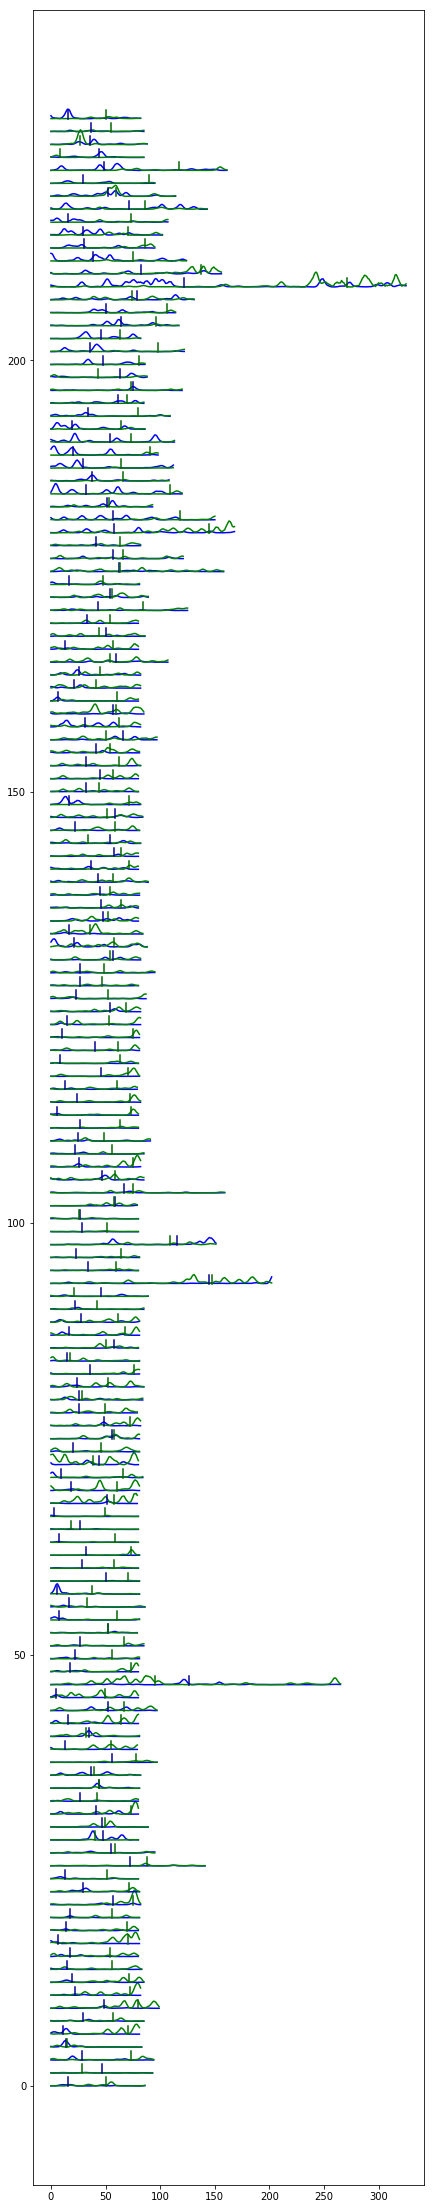

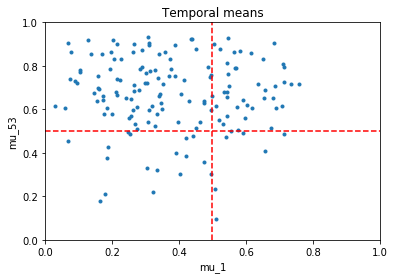

In [44]:
def plot_paired_curves(dataDB, datatype, mousename, selector, cellIdx1, cellIdx2):
    queryDict = {"datatype" : datatype, "mousename" : mousename}
    
    # get data for all cells
    data = dataDB.get_data_from_selector(selector, queryDict)
    
    # extract data for cells 1 and 2
    data1 = [d[cellIdx1] for d in data]
    data2 = [d[cellIdx2] for d in data]
    
    settings = {"metricSettings" : {"directed" : True}, "dropShortTrialsTHR" : 4}
    dataTempMu = metric_by_selector(dataDB,
                                queryDict,
                                "ord_mean",
                                "pr",
                                selector,
                                settings,
                                channelFilter=None)
    
    muCell1 = dataTempMu[cellIdx1]
    muCell2 = dataTempMu[cellIdx2]
    
    # plot series
    shiftPref = 1.5
    plt.figure(figsize=(7, 40))
    for shIdx, (d1, d2, mu1, mu2) in enumerate(zip(data1, data2, muCell1, muCell2)):
        plt.plot(d1 + shiftPref*shIdx, color='blue')
        plt.plot(d2 + shiftPref*shIdx, color='green')
        
        plt.plot([mu1*len(d1), mu1*len(d1)], [shiftPref*shIdx, shiftPref*shIdx + 1], color='darkblue')
        plt.plot([mu2*len(d2), mu2*len(d2)], [shiftPref*shIdx, shiftPref*shIdx + 1], color='darkgreen')
    
    # plot temporal means for both
    plt.figure()
    plt.plot(muCell1, muCell2, '.')
    plt.xlabel("mu_"+str(cellIdx1))
    plt.ylabel("mu_"+str(cellIdx2))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.axhline(y=0.5, linestyle='--', color='r')
    plt.axvline(x=0.5, linestyle='--', color='r')
    plt.title('Temporal means')
    plt.show()
    
plot_paired_curves(dataDB, "deconv", "m060", {"interval" : 8}, 1, 53)

# Testing if Average orderability above null

In [ ]:
def test_average_orderability(dataDB, datatype, phasetype, performance, signCellsSelector=None, haveWaiting=False):    
    # Determine cell filtering
    if signCellsSelector == None:
        signCellsSelector = {'None' : None}
        
    signCellsName, signCellsMouseDict = list(signCellsSelector.items())[0]
    
    
    nMice = len(dataDB.mice)
    
    figTot, axTot = plt.subplots(figsize=(4,4))
    axTot.set_ylabel("AvgBinOrd")
    
    fig, ax = plt.subplots(nrows=2, ncols=nMice, figsize=(nMice*4, 2*4))
    ax[0, 0].set_ylabel("AvgBinOrd")
    ax[1, 0].set_ylabel("Effect tize")
    
    phaseKeys = dataDB.get_phasetype_keys(phasetype, performance, haveWaiting=haveWaiting)
    
    print(phaseKeys)
    
    xDummy = np.arange(1, len(phaseKeys)+1)
    
    fTrueAllLst = []
    fRandAllLst = []
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictThis = {'datatype' : datatype, 'mousename' : mousename, 'performance' : performance}
        
        fTrueLst = []
        fRandLst = []
        effSizeLst = []
        
        for phaseKey in phaseKeys:
        
            # Calculate orderability and temporal means
            settings = {"dropShortTrialsTHR" : 4}
            dataTempMu = metric_by_selector(
                dataDB,
                queryDictThis,
                "ord_mean",
                "rp",
                {phasetype : phaseKey},
                settings,
                channelFilter=signCellsMouseDict)

            func_ABO = avg_bivariate_binary_orderability_from_temporal_mean

            permSettings = {"haveEffectSize":True, "haveMeans":True}
            pValL, pValR, effSize, fTrue, fRand = perm_test(
                func_ABO, dataTempMu, permAxis=1, iterAxis=0, nSample=200, settings=permSettings)
            
            fTrueLst += [fTrue]
            fRandLst += [fRand]
            effSizeLst += [effSize]
            
        fTrueAllLst += [fTrueLst]
        fRandAllLst += [fRandLst]
            
        ax[0, iMouse].set_title(mousename)
        ax[0, iMouse].plot(xDummy, fTrueLst)
        ax[0, iMouse].plot(xDummy, fRandLst, '--r')
        ax[1, iMouse].plot(xDummy, effSizeLst)
        
#         ax[0, iMouse].axvline(x=5.5, linestyle='--', color='y')
#         ax[0, iMouse].axvline(x=8.5, linestyle='--', color='y')
#         ax[1, iMouse].axvline(x=5.5, linestyle='--', color='y')
#         ax[1, iMouse].axvline(x=8.5, linestyle='--', color='y')
        
        ax[0, iMouse].set_ylim([0, None])
        ax[1, iMouse].set_ylim([0, None])
        ax[0, iMouse].set_xticks(xDummy)
        ax[1, iMouse].set_xticks(xDummy)
        ax[0, iMouse].set_xticklabels(phaseKeys)
        ax[1, iMouse].set_xticklabels(phaseKeys)
    
    muTrue =  np.mean(fTrueAllLst, axis=0)
    muRand =  np.mean(fRandAllLst, axis=0)
    stdTrue =  np.std(fTrueAllLst, axis=0)
    
    axTot.set_title('Allmice')
    axTot.plot(xDummy, muTrue, color='blue')
    axTot.fill_between(xDummy, muTrue-stdTrue, muTrue+stdTrue, color='blue', alpha=0.3)
    axTot.plot(xDummy, muRand, '--r')
    
    
#     axTot.axvline(x=5.5, linestyle='--', color='y')
#     axTot.axvline(x=8.5, linestyle='--', color='y')
    axTot.set_ylim([0, None])
    axTot.set_xticks(xDummy)
    axTot.set_xticklabels(phaseKeys)
    
    plt.figure(figTot.number)
    plt.savefig(datatype + '_' + signCellsName + "_orderability_test_by_intervals_allmice.pdf")
    
    plt.figure(fig.number)
    plt.savefig(datatype + '_' + signCellsName + "_orderability_test_by_intervals.pdf")
    plt.show()

In [ ]:
# test_average_orderability(dataDB, queryDict, signCellsMouseDict=None)

for datatype in ['raw', 'deconv']:
     for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
        test_average_orderability(dataDB, datatype, 'semiphase', 'Correct', signCellsSelector={signCellsName:signCells})